# Pytorch x Continual learning a doppia memoria
## Implementazione di una strategia IL2M in un apprendimento class incremental

## Introduzione

Il continual learning è una algoritmo di apprendimento il quale il modello impara un' esperienza alla volta, dove ogni esperienza è composta da un suo dataset di dati. Lo scopo di allenare un modello nel continual learning è di fargli imparare nuove conoscenze, apprese dalle nuove esperienze, senza però scordarsi delle esperienze passate. Questo fenomeno di scordarsi le vecchie conoscenze si chiama **Catastrophic forgetting** e lo scopo principale nel continual learning è mitigare questo problema. Formalmente, un algoritmo di continual learning può essere descritto come:

??? Mettere la formulazione del continual learning ???

In questo notebook verra utilizzato un approccio di continual learning per class incremental, utilizzando un classificatore convoluzionale che andrà a classificare delle immagini dal dataset MNIST, aiutato dall' ausilio della strategia IL2M per mitigare il catastrophic forgetting.

La class incremental è una tipo di sfida nel continual learning dove il modello ad ogni esperienza deve imparare a classificare immagini di etichette mai viste prima. Questo implica che anche la struttura del modello dovrà adattarsi al momento opportuno quando verranno mostrate nuove etichette.

In fondo verranno spiegati il dataset MNIST, la strategia IL2M e la struttura del modello.

In [10]:
#Librerie
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

import Metrics.Graphics as Graphics

Il dataset MNIST è composto da immagini che rappresentano cifre scritte a mano da 0 a 9 e le loro etichette sono il numero scritto nell' immagine.


In [2]:
#Estrazione ed ordinmanento dati in base all' etichetta

TR = datasets.MNIST(root = "Benchmark/data", train = True, download = False)
VL = datasets.MNIST(root = "Benchmark/data", train = False, download = False)

#Converto le immagini in tensori
TransformToTensor = transforms.ToTensor()

TR = list(map(lambda x: (TransformToTensor(x[0]).to(torch.float32), torch.tensor(x[1], dtype = torch.long)), TR))
VL = list(map(lambda x: (TransformToTensor(x[0]).to(torch.float32), torch.tensor(x[1], dtype = torch.long)), VL))

#Mostrare qualche immagine
#Graphics.plot_mnist(TR)

Le distribuzioni dei dati tra training e validation sono del 85.71% e 14.28%, che sono delle buone percentuali considerando che il training ha un impatto più importante nel continual learning, poichè avendo più dati per il training, il modello più difficilmente dimenticherà le vecchie classi (anche se è sempre necessario l' ausilio di una strategia contro il catastrophic forgetting).

Total training values:   60000 elements,  85.71%
Total validation values: 10000 elements,  14.28%


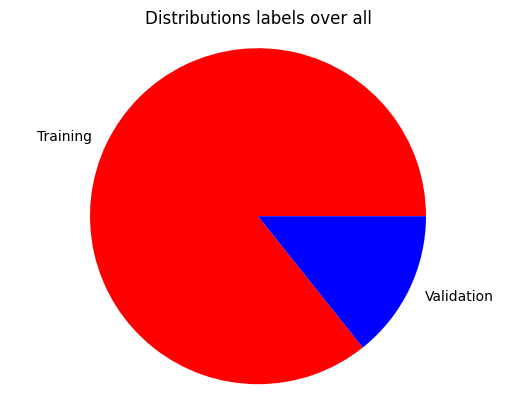

In [11]:
DistributionTR = len(TR) / (len(TR) + len(VL))
DistributionVL = len(VL) / (len(TR) + len(VL))

print(f"Total training values:   {len(TR)} elements,  {int(10000*DistributionTR)/100}%")
print(f"Total validation values: {len(VL)} elements,  {int(10000*DistributionVL)/100}%")

Graphics.CakeGraph([f"Training", f"Validation"], [len(TR), len(VL)], ["red", "blue"], "Distributions labels over all")

Passiamo ora alla distribuzione delle etichette sul dataset. Dai grafici possiamo notare che le distribuzioni delle etichette sono equilibrate, sia sul dataset di validazione ma sopratutto sul dataset di training. Questo ci assicura che il dataset non creerà problemi sul favoreggiamento di alcune classi rispetto ad altre, il che è un bene poichè avendo classi bilanciate su cui allenarsi, il modello non sarà influenzato in modo dominante da etichette specifiche, ottenendo così una buona generalizzazione.

Training labels distributions:

Label 1: 5923 elements, 9.87%
Label 2: 6742 elements, 11.23%
Label 3: 5958 elements, 9.93%
Label 4: 6131 elements, 10.21%
Label 5: 5842 elements, 9.73%
Label 6: 5421 elements, 9.03%
Label 7: 5918 elements, 9.86%
Label 8: 6265 elements, 10.44%
Label 9: 5851 elements, 9.75%
Label 10: 5949 elements, 9.91%


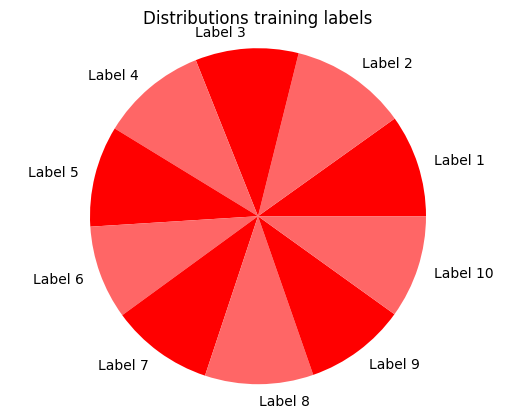

Validation labels distributions:

Label 1: 980 elements, 9.8%
Label 2: 1135 elements, 11.35%
Label 3: 1032 elements, 10.32%
Label 4: 1010 elements, 10.1%
Label 5: 982 elements, 9.82%
Label 6: 892 elements, 8.92%
Label 7: 958 elements, 9.58%
Label 8: 1028 elements, 10.28%
Label 9: 974 elements, 9.74%
Label 10: 1009 elements, 10.09%


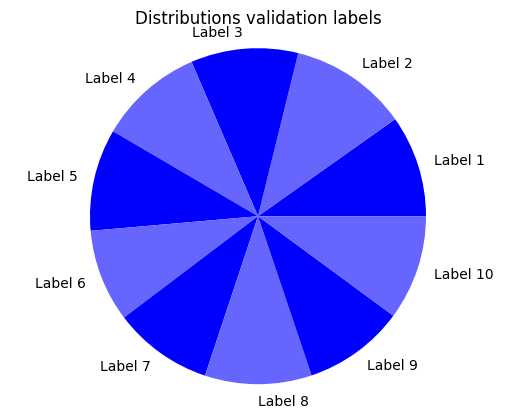

In [4]:
#Distribuzioni etichette e dei task
NumLabelsTR = list(map(lambda x: x[1], TR))
NumLabelsTR = np.array([NumLabelsTR.count(i) for i in range(0, 10)], dtype = np.float64)

NumLabelsVL = list(map(lambda x: x[1], VL))
NumLabelsVL = np.array([NumLabelsVL.count(i) for i in range(0, 10)], dtype = np.float64)

DistributionLabelsTR = NumLabelsTR / np.sum(NumLabelsTR)
DistributionLabelsVL = NumLabelsVL / np.sum(NumLabelsVL)
  
#Etichette del training
print("Training labels distributions:\n")
for i in range(10): print(f"Label {i+1}: {int(NumLabelsTR[i])} elements, {int(10000*DistributionLabelsTR[i])/100}%")
Graphics.CakeGraph([f"Label {i+1}" for i in range(10)], [NumLabelsTR[i] for i in range(10)], [["#ff0000", "#ff6666"][i%2] for i in range(10)], "Distributions training labels")

#Etichette del validation
print("Validation labels distributions:\n")
for i in range(10): print(f"Label {i+1}: {int(NumLabelsVL[i])} elements, {int(10000*DistributionLabelsVL[i])/100}%")
Graphics.CakeGraph([f"Label {i+1}" for i in range(10)], [NumLabelsVL[i] for i in range(10)], [["#0000ff", "#6666ff"][i%2] for i in range(10)], "Distributions validation labels")


Ora si passa alla creazione degli stream. Prima di suddividere i 2 dataset di training **TR** e di validazione **VL** nei 2 stream, i 2 dataset vengono prima ordinati in base all' etichetta, e poi spezzettati nei punti in cui l' etichetta cambia, in questo modo sarà più facile spezzetare i dataset.

In [5]:
#Creazione degli stream

StreamTR = list()
StreamVL = list()

#Ordino i 2 dataset in base alle etichette

TR = sorted(TR, key = lambda x: x[1])
VL = sorted(VL, key = lambda x: x[1])
    
#Faccio lo split dei dataset in experiences, in modo tale da creare gli stream
i1TR, i2TR, i1VL, i2VL = 0, 0, 0, 0

#Per ogni task inserisco i dati con le etichette opportune (sia di training che di validation)
for Labels in [(i, i+1) for i in range(0, 10, 2)]:
    
    while(i2TR < len(TR) and TR[i2TR][1] in Labels): i2TR += 1     
    StreamTR.append(TR[i1TR: i2TR])
    i1TR = i2TR
    
    while(i2VL < len(VL) and VL[i2VL][1] in Labels): i2VL += 1
    StreamVL.append(VL[i1VL: i2VL])
    i1VL = i2VL

Il modello che verrà usato prende in input immagini da 28x28x1 dimensioni (immagini rettangolari da 28 pixel per lato per un canale), e ridà un vettore di logits, dove ogni valore rappresenta una classe. La struttura è una feedforward composta da **3 layer CNN** e **3 layer Fully Connected**. Alla fine, ci sarà una sorta di **Layer estendibile** che aggiungerà un neurone ogni volta che il modello incontrerà una nuova classe.

Il layer estendibile viene esteso dal metodo **AddClass** che, ogni volta che arriva una nuova etichetta, aggiungerà un **layer composto da 1 neurone solo** ad una lista **FinalNeurons**, questa lista appunto rappresenta il layer estendibile.


Da notare che non verrà usata la softmax perchè usando la funzione di loss CrossEntropy non ce ne sarà bisogno, in più nelle memorie della IL2M si lavorerà appunto con i logits del modello.

In [6]:
class ModelCNN(nn.Module):
    
    def __init__(self):
        
        super(ModelCNN, self).__init__()
        
        self.__ClassList = []     #Lista contenenti le classi
        self.__FinalNeurons = []  #Lista contenente i layer con un solo neurone a testa (ogni layer rappresenta una classe).
        
        #Sequenza di layer convoluzionali
        self.__LayerCNN1 = nn.Conv2d(in_channels = 1, out_channels = 5, kernel_size = 7, stride = 2)
        self.__LayerCNN2 = nn.Conv2d(in_channels = 5, out_channels = 3, kernel_size = 5, stride = 1)
        self.__LayerCNN3 = nn.Conv2d(in_channels = 3, out_channels = 1, kernel_size = 3, stride = 1)
        
        #Sequenza di layer densamente conessi
        self.__Fully1 = nn.Linear(25, out_features = 20)
        self.__Fully2 = nn.Linear(20, out_features = 15)
        self.__Fully3 = nn.Linear(15, out_features = 10)
        
        #Layer di softmax
        self.__Softmax = nn.Softmax(dim = 1)
    
    #Metodo di aggiunta di una nuova classe 
    def AddClass(self, Classes):
        
        Classes = set(Classes)
        
        for Class in Classes:
            
            #Se la classe Class non è stata ancora incontrata dal modello, la aggiungo, con il suo layer (con un neurone) associato.
            if(Class not in self.__ClassList):
                self.__ClassList.append(Class)
                self.__FinalNeurons.append(nn.Linear(10, 1))
                
    def GetLabels(self):
        return list(self.__ClassList)
    
    #Operazione di calcolo
    def forward(self, x):
        
        #Fase di passaggio nella convoluzione
        x = self.__LayerCNN1(x)
        x = self.__LayerCNN2(x)
        x = self.__LayerCNN3(x)
        
        #Appiattimento dell' immagine in un vettore
        x = x.view(x.size(0), -1)
        
        #Fase di passaggio negli srati densamente connessi
        x = self.__Fully1(x)
        x = self.__Fully2(x)
        x = self.__Fully3(x)
        
        #Calcolo dei valori su ogni neurone, dove ogni neurone rappresenta una classe
        return torch.cat(tuple([FinalNeuron(x) for FinalNeuron in self.__FinalNeurons]), dim = 1)
    

La strategia usata in questo notebook per mitigare la catastrophic forgetting è la **IL2M**, composta da 2 memorie:

- 1° memoria = Ad ogni esperienza si salva un campione di valori (non tutti perchè la memoria ha capacità ridotta) e cerca di equilibrare le etichette (quindi la distribuzione dei dati in base alla label).

- 2° memoria = si salva le statistiche riguardanti le esperienze passate.

Per capire meglio le statistiche memorizzate nella 2° memoria, consideramo:

- $C_1,\ C_2,\ ...,\ C_P$ come le classi apprese durante le experience passate.
- $P$ lo stato iniziale (cioè prima di iniziare l' allenamento sull' esperienza attuale).
- $N$ lo stato attuale che cambia durante il corso dell' allenamento.

Le statistiche salvate nella 2° memoria sono varie:

- $\mu^P(C_i)$ = Previsione media dei logits su tutti i dati dell' etichetta $C_i$ allo stato $P$.

- $\mu^N(C_i)$ = Previsione media dei logits su tutti i dati dell' etichetta $C_i$ allo stato $N$.

- $\mu(M_N)$ = Predizione media del modello su tutti i dati di training della esperienza attuale allo stato $N$.

- $\mu(M_P)$ = Predizione media del modello su tutti i dati di training della esperienza attuale allo stato $P$.

I valori $\mu^N(C_i)$ e $\mu(M_N)$ vanno aggiornati ad ogni epoca, proprio perchè lo stato $N$ cambia alla fine di ogni epoca, mentre i valori $\mu^P(C_i)$ e $\mu(M_P)$ vanno aggiornati dopo aver finito l' allenamento ma prima di passare alla prossima epoca, questo perchè $P$ è lo stato che ha appreso fino alle ultime classi.

Tutte queste statistiche vengono usate per calcolare un valore, cioè un fattore di scala $p^r(C_i)$, che serve per correggere la bias dei logits, per evitare uno sbilanciamento sulle nuove classi.

$p^r(C_i)$ = p(C_i) \frac{\mu_P(C_i)}{\mu_N(C_i)} \frac{\mu(M_N)}{\mu(M_P)}$

Dove $p(C_i)$ è il valore grezzo del logit durante l' inferenza e $p^r(C_i)$ è il valore del logit rettificato.

Queste 2 memorie hanno 2 scopi diversi, entrambe usate per mitigare il catastrophic forgetting ma in 2 modi diversi:

- I dati della 1° memoria verranno messi insieme al dataset di training dell' esperienza attuale, in modo tale da ricordare al modello come sono fatti i dati delle vecchie classi. La capacità di questa memoria influisce sul ricordare le vecchie classi poichè meno spazio si ha e meno esempi si ha per ogni classe.

- Le statistiche della 2° memoria vengono usate durante l' inferenza (e non durante l' allenamento) per correggere la bias del modello. Essendo che nell' esperienza attuale il modello sarà più predisposto a rispondere con le etichette del task attuale, se il modello su una predizione sta per rispondere ad un task nuovo (lo si può vedere dai logits), allora i logits corrispondenti delle classi vecchie vengono rettificati, altrimenti non serve.

In [7]:
#Aggiunta del metodo IL2M al modello
class StrategyIL2M:
    
    def __init__(self):
        
        self.__FirstMemory = StrategyIL2M.BalancedBuffer(1000)
        self.__SecondMemory = StrategyIL2M.StatisticalBuffer()
        
    def GetBalancedMemory(self):
        return self.__FirstMemory
    
    def GetStatisticalMemory(self):
        return self.__SecondMemory
    
    class StatisticalBuffer:
        
        def __init__(self):
            
            self.__MeanClassStart = dict() #Da aggiornare alla fine delle epoche
            self.__MeanClassActual = dict() #Da aggiornare alla fine di ogni epoca
            
            self.__TotalMeanModelStart = 0 #Da aggiornare alla fine di tutte le epoche
            self.__TotalMeanModelActual = 0 #Da aggiornare alla fine di ogni epoca
            
        def __str__(self):
            
            Result = ""
            
            Result += f"Media delle classi stato iniziale: {self.__MeanClassStart}\n"
            Result += f"Media delle clasi stato attuale: {self.__MeanClassActual}\n"
            Result += f"Media dei risultati stato iniziale: {self.__TotalMeanModelStart}\n"
            Result += f"Media dei risultati stato attuale: {self.__TotalMeanModelActual}\n"
            
            return Result    
            
        def SetMeanModelLabelStart(self, Mean, Label):
            self.__MeanClassStart[Label] = Mean
            
        def SetMeanModelLabelActual(self, Mean, Label):
            self.__MeanClassActual[Label] = Mean
            
        def SetTotalMeanModelStart(self, Mean):
            self.__TotalMeanModelStart = Mean
            
        def SetTotalMeanModelActual(self, Mean):
            self.__TotalMeanModelActual = Mean
            
        def GetRefineLogitClass(self, Label):
            return (self.__MeanClassStart[Label] / self.__MeanClassActual[Label]) * (self.__TotalMeanModelActual / self.__TotalMeanModelStart)

    class BalancedBuffer:
        
        def __init__(self, Len):
            
            self.__Len = Len 
            self.__Data = dict()
            
        def GetDataDict(self):
            return {label: self.__Data[label] for label in self.__Data.keys()}
          
        def GetData(self):
            
            Inputs = []
            Outputs = []
            
            for key in self.__Data.keys():
                
                Inputs += self.__Data[key]
                Outputs += [key]*len(self.__Data[key])
                       
            return [(i[0], torch.tensor(i[1], dtype = torch.long)) for i in zip(Inputs, Outputs)]
        
        #Aggiungo un elemento al buffer
        def AddData(self, x):
            
            #Se il limite di memoria è stato raggiunto cerco di capire quale elemento devo togliere, per tener bilanciato il buffer tra le classi
            if(np.sum([len(x) for x in self.__Data.values()]) >= self.__Len):
                
                #Cerco l' etichetta con la distribuzione maggiore e tolgo un elemento da essa
                Distributions = self.GetCountsLabels()
                
                Max = 0
                MaxLabel = None
                
                for Label in Distributions.keys():
                    
                    if(Distributions[Label] > Max):
                        Max = Distributions[Label]
                        MaxLabel = Label
                
                #Rimuovo il logits con l' etichetta dominante      
                self.RemoveData(MaxLabel)
                
            if(int(x[1].detach().numpy()) not in self.__Data.keys()): self.__Data[int(x[1].detach().numpy())] = [x[0]]
            else: self.__Data[int(x[1].detach().numpy())].append(x[0])
       
        #Tolgo un elemento dal buffer che ha come etichetta la "Label"
        def RemoveData(self, Label):
            del self.__Data[Label][0]

        #Ridò il conteggio delle etichette
        def GetCountsLabels(self):
            return {Key: len(self.__Data[Key]) for Key in self.__Data.keys()}
             

In [8]:
Model = ModelCNN()

IL2M = StrategyIL2M()

LossFunction = nn.CrossEntropyLoss()
Optimizer = optim.SGD(Model.parameters())

#Ogni dizionario rappresenta la loss su ogni etichetta su un experience
LossesTR = [] 
LossesVL = []

Exp = 0

TotalExperienceVL = []

#Sullo scorrere dello stream
for ExperienceTR, ExperienceVL in zip(StreamTR[:2], StreamVL[:2]):
    
    FromPastData = IL2M.GetBalancedMemory().GetData()
    
    #Se ci sono dati dal buffer da aggiungere (cioè questo non è la 1° experience), salvo i dati contenuti dalla 1° memoria di IL2M
    if(len(FromPastData) > 0):  ExperienceTR += FromPastData
    
    #Preparo il necessario per dopo quando vado a salvarmi i dati e le statistiche nelle memorie IL2M
    Inputs, Outputs = [list(i) for i in zip(*ExperienceTR)]
    AllLogitsTR = [list(i) for i in zip(Inputs, Outputs)]
    LabelsTR = np.array(list(map(lambda x: x[1], AllLogitsTR)))
    
    TotalExperienceVL += ExperienceVL
     
    #Preparo i dataset   
    ActualTR = DataLoader(ExperienceTR, batch_size = 600, shuffle = True)
    ActualVL = DataLoader(TotalExperienceVL, batch_size = len(ExperienceVL))

    #Un ciclo di allenamento e validazione per ogni esperienza
    for epoch in range(2):
        
        Model.train()
        
        #Alleno il modello
        for BatchInput, BatchOutput in ActualTR:
            
            Model.AddClass(BatchOutput)
        
            Outputs = Model(BatchInput)
            Loss = LossFunction(Outputs, BatchOutput)
            
            Optimizer.zero_grad()
            Loss.backward()
            Optimizer.step()
            
        #Valuto il modello
        Model.eval()
        
        LossTR = np.array([])
        LossVL = np.array([])
        
        with torch.no_grad():
            
            #Aggiorno i statistiche da mettere dentro la seconda memoria (le statistiche da calcolare con lo stato attuale)
        
            OutputsModel = Model(torch.cat(Inputs, dim = 0).unsqueeze(1))
            
            #Per ogni label di questa esperienza, vado ad aggiungere le statistiche delle medie per ogni etichetta(e di p(C_i))
            for label in set(LabelsTR):
                
                LabelsIndexes = np.where(LabelsTR == label)[0]
                MeanModelLabel = torch.mean(torch.cat(tuple([OutputsModel[i] for i in LabelsIndexes]), dim = 0))
                IL2M.GetStatisticalMemory().SetMeanModelLabelActual(MeanModelLabel, label)

            IL2M.GetStatisticalMemory().SetTotalMeanModelActual(torch.mean(OutputsModel))
            
            LabelsVL = np.array(list(map(lambda x: x[1], TotalExperienceVL)))
            
            #Mi salvo le loss su questa experience
            
            #Calcolo delle loss di TR
            BatchInputs, BatchOutputs = [list(i) for i in zip(*ExperienceTR)]
            BatchModelOutputs = Model(torch.cat(BatchInputs, dim = 0).unsqueeze(1))
            
            #Usa le statistiche della seconda memoria per sistemare la bias su BatchModelOutputs
            MaskRectification = torch.isin(torch.argmax(BatchModelOutputs, dim = 1), torch.tensor([Exp*2, (Exp*2)+1]))
            BatchModelOutputs[MaskRectification] *= torch.tensor([IL2M.GetStatisticalMemory().GetRefineLogitClass(i) for i in range(Exp*2)] + [1, 1])
            
            LossExperience = dict()
            for label in set(LabelsTR):   
                LabelsIndex = np.where(LabelsTR == label)[0]
                LossExperience[label] = LossFunction(torch.stack([BatchModelOutputs[i] for i in LabelsIndex]), 
                                                     torch.stack([BatchOutputs[i] for i in LabelsIndex]))
            LossesTR.append(LossExperience)
            
            #Calcolo delle loss di VL
            BatchInputs, BatchOutputs = [list(i) for i in zip(*TotalExperienceVL)]
            BatchModelOutputs = Model(torch.cat(Inputs, dim = 0).unsqueeze(1)) 
            
            #Usa le statistiche della seconda memoria per sistemare la bias su BatchModelOutputs
            MaskRectification = torch.isin(torch.argmax(BatchModelOutputs, dim = 1), torch.tensor([Exp*2, (Exp*2)+1]))
            BatchModelOutputs[MaskRectification] *= torch.tensor([IL2M.GetStatisticalMemory().GetRefineLogitClass(i) for i in range(Exp*2)] + [1, 1])
            
            LossExperience = dict()
            for label in set(LabelsVL):
                LabelsIndex = np.where(LabelsVL == label)[0]
                LossExperience[label] = LossFunction(torch.stack([BatchModelOutputs[i] for i in LabelsIndex]), 
                                                     torch.stack([BatchOutputs[i] for i in LabelsIndex]))
            LossesVL.append(LossExperience)

        print(f"Experience: {Exp+1} and Epoch {epoch+1}")      
        for label in LossesTR[-1].keys(): print(f"Label {label} training loss: {LossesTR[-1][label]}")
        for label in LossesVL[-1].keys(): print(f"Label {label} validation loss: {LossesVL[-1][label]}")
        print("")

    #Mi salvo le informazioni da mettere dentro la mia IL2M
    
    #Inserisco i dati scelti dentro il buffer bilanciato
    with torch.no_grad():
    
        ChoicedLogitsIndex = np.concatenate((
                                np.random.choice(np.where(LabelsTR == torch.tensor((Exp*2)))[0], size = 500, replace = False),
                                np.random.choice(np.where(LabelsTR == torch.tensor((Exp*2)+1))[0], size = 500, replace = False)), axis = 0)
        
        [IL2M.GetBalancedMemory().AddData(AllLogitsTR[i]) for i in ChoicedLogitsIndex]
        
        #Mi salvo le statistiche riguardanti questa esperienza (quindi da mettere nella seconda memoria)
        OutputsModel = Model(torch.cat(Inputs, dim = 0).unsqueeze(1))
        
        for label in set(LabelsTR):
            
            LabelsIndexes = np.where(LabelsTR == label)[0]
            MeanModelLabel = torch.mean(torch.cat(tuple([OutputsModel[i] for i in LabelsIndexes]), dim = 0))
            IL2M.GetStatisticalMemory().SetMeanModelLabelStart(MeanModelLabel, label)
            
        IL2M.GetStatisticalMemory().SetTotalMeanModelStart(torch.mean(OutputsModel))

    Exp += 1



Experience: 1 and Epoch 1
Label 0 training loss: 0.5391079783439636
Label 1 training loss: 0.8871448040008545
Label 0 validation loss: 0.5393079519271851
Label 1 validation loss: 0.8756387233734131

Experience: 1 and Epoch 2
Label 0 training loss: 0.5398397445678711
Label 1 training loss: 0.8854201436042786
Label 0 validation loss: 0.5400296449661255
Label 1 validation loss: 0.8746114373207092

Experience: 2 and Epoch 1
Label 0 training loss: 1.346224069595337
Label 1 training loss: 1.7118031978607178
Label 2 training loss: 1.06968355178833
Label 3 training loss: 1.549849271774292
Label 0 validation loss: 1.3370453119277954
Label 1 validation loss: 1.6948914527893066
Label 2 validation loss: 1.0690702199935913
Label 3 validation loss: 1.5579125881195068

Experience: 2 and Epoch 2
Label 0 training loss: 1.352445363998413
Label 1 training loss: 1.714486002922058
Label 2 training loss: 1.0665963888168335
Label 3 training loss: 1.5447367429733276
Label 0 validation loss: 1.3432823419570923

In [9]:
print(LossesTR)

PlotLossTR = dict()
for i in range(10): PlotLossTR[i] = []
for Losses in LossesTR:
    for i in range(10):
        PlotLossTR[i] += Losses[i]


[print(len(i) for i in LossesTR)]

[{0: tensor(0.5391), 1: tensor(0.8871)}, {0: tensor(0.5398), 1: tensor(0.8854)}, {0: tensor(1.3462), 1: tensor(1.7118), 2: tensor(1.0697), 3: tensor(1.5498)}, {0: tensor(1.3524), 1: tensor(1.7145), 2: tensor(1.0666), 3: tensor(1.5447)}]


TypeError: iteration over a 0-d tensor

Referenze:

- Paper da dove mi sono informato per la IL2M: ""